# Lab 6: Multi-Agent Orchestration with Microsoft Agent Framework

Extend single agents into **coordinated multi-agent systems** using the orchestration patterns from Microsoft Agent Framework.

## Learning Objectives

By the end of this lab, you will:
1. Understand **why multi-agent systems** outperform single agents for complex tasks
2. Implement **5 orchestration patterns**: Concurrent, Sequential, Group Chat, Magentic, Handoff
3. Know **when to use** each pattern based on your use case
4. Build a **real-world multi-agent application** for research assistance

## Prerequisites

| Requirement | Setup |
|------------|-------|
| Lab 3 completed | Single agent with tool calling |
| Python environment | Run `uv sync --all-extras --dev` from project root |
| Azure CLI logged in | Run `az login` in terminal |
| Azure AI Foundry Project | [Create at ai.azure.com](https://ai.azure.com) |

### Model Deployment Options

The `AZURE_AI_MODEL_DEPLOYMENT_NAME` is the **deployment name** of your LLM in Azure AI Foundry. You can use **any chat completion model** you have deployed:

| Model Family | Example Deployment Names | Notes |
|--------------|-------------------------|-------|
| **GPT-4o** | `gpt-4o`, `gpt-4o-mini` | Recommended for most use cases |
| **GPT-4.1** | `gpt-4.1`, `gpt-4.1-mini`, `gpt-4.1-nano` | Newer model with improved capabilities |
| **GPT-5** | `gpt-5`, `gpt-5-mini` | If available in your region |
| **Other** | Any deployed model name | Any model supporting tool calling |

<br> 

> **💡 Tip**: The deployment name is what YOU named it when deploying in AI Foundry, not the model name. Check your [AI Foundry deployments](https://ai.azure.com) to find your deployment name.

## Environment Variables

Same as Lab 3 - your `.env` file should have:

```bash
AZURE_AI_PROJECT_ENDPOINT=https://your-project.services.ai.azure.com
AZURE_AI_MODEL_DEPLOYMENT_NAME=gpt-4o  # Change to YOUR deployment name!
```

## Why Multi-Agent Systems?

**Single agents** are powerful but have limitations:

| Limitation | Multi-Agent Solution |
|------------|----------------------|
| Context window limits | Distribute context across specialized agents |
| Single perspective | Multiple expert viewpoints on the same problem |
| Sequential bottleneck | Parallel processing with concurrent agents |
| Complex reasoning | Break down into agent collaboration |
| Quality control | Reviewer agents validate work |

### The Key Insight

> **Multi-agent systems** treat agents as team members, each with specialized skills, who collaborate to solve problems that would overwhelm a single agent.

```
┌─────────────────────────────────────────────────────────────────────┐
│                    Single Agent vs Multi-Agent                      │
├─────────────────────────────┬───────────────────────────────────────┤
│       Single Agent          │           Multi-Agent                 │
│                             │                                       │
│   ┌─────────────────┐       │    ┌─────────┐  ┌─────────┐           │
│   │                 │       │    │Researcher│  │ Writer  │          │
│   │   One Agent     │       │    └────┬────┘  └────┬────┘           │
│   │   Does All      │       │         │            │                │
│   │                 │       │    ┌────┴────────────┴────┐           │
│   └─────────────────┘       │    │    Orchestrator      │           │
│                             │    └──────────┬───────────┘           │
│   ✗ Context limits          │               │                       │
│   ✗ Single perspective      │    ┌──────────┴───────────┐           │
│   ✗ No collaboration        │    │ Reviewer │ │ Analyst │           │
│                             │    └──────────┘ └─────────┘           │ 
│                             │                                       │
│                             │   ✓ Specialized expertise             │
│                             │   ✓ Parallel processing               │
│                             │   ✓ Collaborative refinement          │
└─────────────────────────────┴───────────────────────────────────────┘
```

## The 5 Orchestration Patterns

Microsoft Agent Framework provides **5 built-in orchestration patterns**:

| Pattern | Topology | Description | Best For |
|---------|----------|-------------|----------|
| **Concurrent** | Fan-out | All agents process the same task in parallel | Parallel analysis, ensemble reasoning |
| **Sequential** | Pipeline | Each agent passes results to the next | Step-by-step workflows, multi-stage processing |
| **Group Chat** | Star (manager) | Central manager coordinates turn-taking | Iterative refinement, collaborative problem-solving |
| **Magentic** | Star (planner) | Manager with planning for complex tasks | Complex, generalist multi-agent collaboration |
| **Handoff** | Mesh | Agents pass control dynamically without central manager | Dynamic workflows, expert escalation |

### Visual Comparison

```
┌──────────────────┐  ┌──────────────────┐  ┌──────────────────┐
│    CONCURRENT    │  │    SEQUENTIAL    │  │    GROUP CHAT    │
│                  │  │                  │  │                  │
│      Input       │  │  A ──▶ B ──▶ C   │  │    ┌────────┐    │
│        │         │  │                  │  │    │Manager │    │
│    ┌───┼───┐     │  │  Pipeline flow   │  │    └───┬────┘    │
│    ▼   ▼   ▼     │  │                  │  │   ┌────┼────┐    │
│   [A] [B] [C]    │  │                  │  │   ▼    ▼    ▼    │
│    │   │   │     │  │                  │  │  [A]  [B]  [C]   │
│    └───┼───┘     │  │                  │  │                  │
│        ▼         │  │                  │  │  Star topology   │
│     Aggregate    │  │                  │  │                  │
└──────────────────┘  └──────────────────┘  └──────────────────┘

┌──────────────────┐  ┌──────────────────┐
│     MAGENTIC     │  │      HANDOFF     │
│                  │  │                  │
│  ┌───────────┐   │  │  [A]◀──────▶[B]  │
│  │  Planner  │   │  │   │\        /│   │
│  │  Manager  │   │  │   │ \      / │   │
│  └─────┬─────┘   │  │   │  \    /  │   │
│   ┌────┼────┐    │  │   │   \  /   │   │
│   ▼    ▼    ▼    │  │   ▼    \/    ▼   │
│  [A]  [B]  [C]   │  │  [C]◀──────▶[D]  │
│                  │  │                  │
│  With planning   │  │  Mesh topology   │
│  & progress      │  │  Direct handoffs │
└──────────────────┘  └──────────────────┘
```

## Step 1: Setup and Imports

In [1]:
import os
import json
import asyncio
from pathlib import Path
from typing import Annotated, Any

from dotenv import load_dotenv

# Ensure Azure CLI is in PATH (needed for notebook kernel)
homebrew_paths = ["/opt/homebrew/bin", "/usr/local/bin"]
current_path = os.environ.get("PATH", "")
for p in homebrew_paths:
    if p not in current_path:
        os.environ["PATH"] = p + ":" + current_path
        current_path = os.environ["PATH"]

# Load environment variables
env_path = Path("../.env")
if env_path.exists():
    load_dotenv(env_path)
    print(f"✅ Loaded .env from {env_path.resolve()}")
else:
    load_dotenv()
    print("⚠️  No .env found in parent directory")

# Verify required env vars for Lab 6
required_vars = ["AZURE_OPENAI_ENDPOINT", "AZURE_AI_MODEL_DEPLOYMENT_NAME", "AZURE_AI_API_KEY"]
missing = [v for v in required_vars if not os.getenv(v)]
if missing:
    print(f"❌ Missing environment variables: {missing}")
else:
    print("✅ Environment configured")
    print(f"   Endpoint: {os.getenv('AZURE_OPENAI_ENDPOINT')}")
    print(f"   Model: {os.getenv('AZURE_AI_MODEL_DEPLOYMENT_NAME')}")
    print(f"   API Key: {'*' * 8}...{os.getenv('AZURE_AI_API_KEY')[-4:]}")

✅ Loaded .env from /Users/pablo/Desktop/githubRepos/teaching/northwestern/northwestern-fy26-msai-foundry-agentic-ai/.env
✅ Environment configured
   Endpoint: https://agent-service-demo.openai.azure.com/
   Model: gpt-4.1
   API Key: ********...CTo3


## Step 2: Install Microsoft Agent Framework

Microsoft Agent Framework is a Python library for building multi-agent systems. It provides:
- **Agent abstractions** - Create agents with instructions and tools
- **Orchestration patterns** - Built-in patterns for agent coordination
- **Azure integration** - Native support for Azure OpenAI and AI Foundry

In [2]:
# Install the Microsoft Agent Framework
# Note: This package is still in preview - requires --pre flag
%pip install -q agent-framework --pre

print("\n✅ Microsoft Agent Framework installed")

/Users/pablo/Desktop/githubRepos/teaching/northwestern/northwestern-fy26-msai-foundry-agentic-ai/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.

✅ Microsoft Agent Framework installed


## Step 3: Create the Chat Client

The `AzureOpenAIChatClient` is the foundation for creating agents. It connects to your Azure OpenAI deployment.

**Key Concept**: A single chat client can create multiple agents, each with different instructions and tools.

### Environment Variables

The client reads from these environment variables automatically:
- `AZURE_OPENAI_ENDPOINT` or `AZURE_AI_PROJECT_ENDPOINT`
- `AZURE_OPENAI_CHAT_DEPLOYMENT_NAME` or `AZURE_AI_MODEL_DEPLOYMENT_NAME`

Or you can pass them explicitly to the constructor.

In [3]:
from agent_framework.azure import AzureOpenAIChatClient

# Initialize the Azure OpenAI chat client
# Uses Azure OpenAI endpoint (not AI Foundry project endpoint)
chat_client = AzureOpenAIChatClient(
    api_key=os.getenv("AZURE_AI_API_KEY"),
    endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    deployment_name=os.getenv("AZURE_AI_MODEL_DEPLOYMENT_NAME"),
    api_version="2024-12-01-preview",
)

print("✅ Azure OpenAI Chat Client initialized")
print(f"   Endpoint: {os.getenv('AZURE_OPENAI_ENDPOINT')}")
print(f"   Deployment: {os.getenv('AZURE_AI_MODEL_DEPLOYMENT_NAME')}")

✅ Azure OpenAI Chat Client initialized
   Endpoint: https://agent-service-demo.openai.azure.com/
   Deployment: gpt-4.1


In [4]:
# Test the chat client with a simple message
response = await chat_client.get_response(messages="hello world")
print(f"✅ Response received!")
print(f"   Content: {response.text}")

✅ Response received!
   Content: Hello! 🌍 How can I help you today?


# Pattern 1: Concurrent Orchestration

## When to Use

- **Parallel analysis** - Multiple experts analyze the same input
- **Ensemble reasoning** - Combine diverse perspectives
- **Independent subtasks** - Tasks don't depend on each other

## Architecture

```
                    User Input
                        │
          ┌─────────────┼─────────────┐
          │             │             │
          ▼             ▼             ▼
    ┌──────────┐  ┌──────────┐  ┌──────────┐
    │Researcher│  │ Marketer │  │  Legal   │
    │          │  │          │  │          │
    └────┬─────┘  └────┬─────┘  └────┬─────┘
         │             │             │
         └─────────────┼─────────────┘
                       │
                       ▼
               Aggregated Results
```

**How it works**:
1. Same input is broadcast to all agents
2. Agents process **in parallel** (no dependencies)
3. Results are **aggregated** at the end

In [5]:
from agent_framework import ConcurrentBuilder, ChatMessage, WorkflowOutputEvent, Role

# ============================================================
# STEP 1: Create specialized agents
# ============================================================

# Each agent has a unique perspective on the same problem
researcher = chat_client.as_agent(
    instructions=(
        "You're an expert market and product researcher. Given a prompt, provide concise, "
        "factual insights, opportunities, and risks. Focus on data-driven analysis."
    ),
    name="researcher",
)

marketer = chat_client.as_agent(
    instructions=(
        "You're a creative marketing strategist. Craft compelling value propositions "
        "and target messaging aligned to the prompt. Focus on audience and messaging."
    ),
    name="marketer",
)

legal = chat_client.as_agent(
    instructions=(
        "You're a cautious legal/compliance reviewer. Highlight constraints, disclaimers, "
        "and policy concerns. Focus on risk mitigation and compliance."
    ),
    name="legal",
)

print("✅ Created 3 specialized agents:")
print("   • researcher - Market analysis")
print("   • marketer - Marketing strategy")
print("   • legal - Compliance review")

✅ Created 3 specialized agents:
   • researcher - Market analysis
   • marketer - Marketing strategy
   • legal - Compliance review


In [6]:
# ============================================================
# STEP 2: Build the Concurrent Workflow
# ============================================================

concurrent_workflow = (
    ConcurrentBuilder()
    .participants([researcher, marketer, legal])  # All agents receive the same input
    .build()
)

print("✅ Concurrent workflow built")
print("   All 3 agents will process the input in parallel")

✅ Concurrent workflow built
   All 3 agents will process the input in parallel


In [7]:
# ============================================================
# STEP 3: Run the Concurrent Workflow
# ============================================================


async def run_concurrent_demo():
    """Run the concurrent workflow and display results."""

    task = "We are launching a new AI-powered tutoring app for graduate students."

    print(f"📝 Task: {task}")
    print("\n" + "=" * 70)
    print("Running concurrent analysis (all agents work in parallel)...")
    print("=" * 70 + "\n")

    output_evt = None
    async for event in concurrent_workflow.run_stream(task):
        if isinstance(event, WorkflowOutputEvent):
            output_evt = event

    if output_evt:
        print("===== Aggregated Results from All Agents =====")
        messages = output_evt.data
        for i, msg in enumerate(messages, start=1):
            name = msg.author_name if msg.author_name else "user"
            print(f"\n{'-' * 60}")
            print(f"{i:02d} [{name.upper()}]")
            print(f"{'-' * 60}")
            print(msg.text[:500] + "..." if len(msg.text) > 500 else msg.text)


# Run the demo
await run_concurrent_demo()

📝 Task: We are launching a new AI-powered tutoring app for graduate students.

Running concurrent analysis (all agents work in parallel)...

===== Aggregated Results from All Agents =====

------------------------------------------------------------
01 [USER]
------------------------------------------------------------
We are launching a new AI-powered tutoring app for graduate students.

------------------------------------------------------------
02 [RESEARCHER]
------------------------------------------------------------
**Insights**

- **Market Opportunity**: Demand for personalized learning among graduate students is growing, especially in STEM, business, and health sciences. The market for AI-powered edtech was valued at ~$2.5B in 2023 and is projected to grow at 30%+ CAGR (HolonIQ).
- **Competitive Landscape**: Key players include Chegg, Course Hero, and niche AI apps like Socratic by Google. Few focus specifically on graduate-level rigor and research assistance.
- **User Needs*

### Key Takeaways: Concurrent Pattern

| Aspect | Details |
|--------|--------|
| **Execution** | All agents run simultaneously |
| **Dependencies** | None - agents are independent |
| **Output** | Aggregated list of all responses |
| **Best for** | Getting multiple perspectives quickly |

# Pattern 2: Sequential Orchestration

## When to Use

- **Pipeline processing** - Each step builds on the previous
- **Multi-stage workflows** - Draft → Review → Polish
- **Dependent transformations** - Output becomes next input

## Architecture

```
    User Input
        │
        ▼
  ┌──────────┐     Full context
  │  Writer  │────────────────────┐
  └────┬─────┘                    │
       │                          ▼
       │ output            ┌──────────┐
       └──────────────────▶│ Reviewer │
                           └────┬─────┘
                                │
                                ▼
                          Final Output
```

**How it works**:
1. First agent processes input
2. **Full conversation history** passes to next agent
3. Each agent builds on previous work

In [8]:
from agent_framework import SequentialBuilder

# ============================================================
# STEP 1: Create pipeline agents
# ============================================================

# Writer creates initial content
writer = chat_client.as_agent(
    instructions=(
        "You are a concise copywriter. Write a compelling marketing paragraph "
        "based on the prompt. Keep it under 100 words."
    ),
    name="writer",
)

# Reviewer provides feedback
reviewer = chat_client.as_agent(
    instructions=(
        "You are a thoughtful content reviewer. Provide brief, constructive feedback "
        "on the previous message. Suggest 2-3 specific improvements."
    ),
    name="reviewer",
)

# Editor creates final version
editor = chat_client.as_agent(
    instructions=(
        "You are a skilled editor. Based on the original content and feedback, "
        "create an improved final version. Apply the reviewer's suggestions."
    ),
    name="editor",
)

print("✅ Created 3 pipeline agents:")
print("   writer → reviewer → editor")

✅ Created 3 pipeline agents:
   writer → reviewer → editor


In [9]:
# ============================================================
# STEP 2: Build the Sequential Workflow
# ============================================================

sequential_workflow = (
    SequentialBuilder()
    .participants([writer, reviewer, editor])  # Order matters!
    .build()
)

print("✅ Sequential workflow built")
print("   Pipeline: writer → reviewer → editor")

✅ Sequential workflow built
   Pipeline: writer → reviewer → editor


In [10]:
# ============================================================
# STEP 3: Run the Sequential Workflow
# ============================================================


async def run_sequential_demo():
    """Run the sequential workflow showing the pipeline."""

    task = "Write a tagline for an AI-powered research assistant for PhD students."

    print(f"📝 Task: {task}")
    print("\n" + "=" * 70)
    print("Running sequential pipeline (writer → reviewer → editor)...")
    print("=" * 70 + "\n")

    output_evt = None
    async for event in sequential_workflow.run_stream(task):
        if isinstance(event, WorkflowOutputEvent):
            output_evt = event

    if output_evt:
        print("===== Pipeline Results =====")
        messages = output_evt.data
        for i, msg in enumerate(messages, start=1):
            name = msg.author_name or ("assistant" if msg.role == Role.ASSISTANT else "user")
            print(f"\n{'-' * 60}")
            print(f"Step {i}: [{name.upper()}]")
            print(f"{'-' * 60}")
            print(msg.text)


# Run the demo
await run_sequential_demo()

📝 Task: Write a tagline for an AI-powered research assistant for PhD students.

Running sequential pipeline (writer → reviewer → editor)...

===== Pipeline Results =====

------------------------------------------------------------
Step 1: [USER]
------------------------------------------------------------
Write a tagline for an AI-powered research assistant for PhD students.

------------------------------------------------------------
Step 2: [WRITER]
------------------------------------------------------------
Accelerate your insights: The AI-powered research assistant designed for PhD brilliance.

------------------------------------------------------------
Step 3: [REVIEWER]
------------------------------------------------------------
Feedback:

1. While "Accelerate your insights" is engaging, it could be more directly relevant to the academic work of PhD students—consider referencing tasks like literature review or data analysis.
2. "Designed for PhD brilliance" is positive, but 

### Key Takeaways: Sequential Pattern

| Aspect | Details |
|--------|--------|
| **Execution** | One agent at a time, in order |
| **Context** | Full conversation history passed forward |
| **Dependencies** | Each agent depends on previous output |
| **Best for** | Draft → Review → Finalize workflows |

# Pattern 3: Group Chat Orchestration

## When to Use

- **Iterative refinement** - Multiple rounds of discussion
- **Collaborative problem-solving** - Agents debate and refine
- **Controlled conversations** - Manager decides who speaks

## Architecture

```
                    User Input
                        │
                        ▼
               ┌────────────────┐
               │   Orchestrator │  ◀── Decides who speaks next
               │    (Manager)   │
               └───────┬────────┘
              ┌────────┼────────┐
              │        │        │
              ▼        ▼        ▼
        ┌─────────┐ ┌─────────┐ ┌─────────┐
        │Researcher│ │ Writer  │ │Reviewer │
        └─────────┘ └─────────┘ └─────────┘
              │        │        │
              └────────┼────────┘
                       │
                       ▼
              All see full history
```

**How it works**:
1. **Orchestrator** selects which agent speaks next
2. All agents see the **full conversation history**
3. **Iterative** - conversation continues until termination condition

In [11]:
from agent_framework import GroupChatBuilder, GroupChatState, ChatAgent

# ============================================================
# STEP 1: Create group chat agents
# ============================================================

# Using ChatAgent directly with the chat_client
gc_researcher = ChatAgent(
    name="Researcher",
    description="Collects relevant background information.",
    instructions="Gather concise facts that help answer the question. Be brief and factual. Max 50 words.",
    chat_client=chat_client,
)

gc_writer = ChatAgent(
    name="Writer",
    description="Synthesizes polished answers using gathered information.",
    instructions="Compose clear, structured answers using the research. Be comprehensive but concise.",
    chat_client=chat_client,
)

gc_critic = ChatAgent(
    name="Critic",
    description="Reviews and improves the written content.",
    instructions="Review the Writer's output. Suggest specific improvements. Be constructive.",
    chat_client=chat_client,
)

print("✅ Created 3 group chat agents:")
print("   • Researcher - Gathers facts")
print("   • Writer - Creates content")
print("   • Critic - Reviews and improves")

✅ Created 3 group chat agents:
   • Researcher - Gathers facts
   • Writer - Creates content
   • Critic - Reviews and improves


In [12]:
# ============================================================
# STEP 2: Define Speaker Selection Logic
# ============================================================


def round_robin_selector(state: GroupChatState) -> str:
    """
    Simple round-robin speaker selection.
    Rotates through participants based on the current round.
    """
    participant_names = list(state.participants.keys())
    selected = participant_names[state.current_round % len(participant_names)]
    print(f"   🎯 Selector chose: {selected} (round {state.current_round})")
    return selected


print("✅ Defined round-robin speaker selector")

✅ Defined round-robin speaker selector


In [17]:
# ============================================================
# STEP 3: Build the Group Chat Workflow
# ============================================================

group_chat_workflow = (
    GroupChatBuilder()
    .with_select_speaker_func(round_robin_selector)
    .participants([gc_researcher, gc_writer, gc_critic])
    # Terminate after 4 turns: Researcher → Writer → Critic → Writer
    .with_termination_condition(lambda conversation: len(conversation) >= 5)
    .build()
)

print("✅ Group chat workflow built")
print("   Termination: After 4 agent turns")

✅ Group chat workflow built
   Termination: After 4 agent turns


In [18]:
# ============================================================
# STEP 4: Run the Group Chat
# ============================================================


async def run_group_chat_demo():
    """Run group chat with streaming output."""

    task = "What are the key benefits of using AI agents in education?"

    print(f"📝 Task: {task}")
    print("\n" + "=" * 70)
    print("Running group chat (manager selects speakers)...")
    print("=" * 70 + "\n")

    output_event = None

    async for event in group_chat_workflow.run_stream(task):
        if isinstance(event, WorkflowOutputEvent):
            output_event = event

    # Display the conversation from the output event
    if output_event:
        print("===== Group Chat Conversation =====")
        messages = output_event.data
        for i, msg in enumerate(messages, start=1):
            name = msg.author_name or ("assistant" if msg.role == Role.ASSISTANT else "user")
            print(f"\n{'-' * 60}")
            print(f"Turn {i}: [{name.upper()}]")
            print(f"{'-' * 60}")
            print(msg.text[:500] + "..." if len(msg.text) > 500 else msg.text)

    print("\n" + "=" * 70)
    print("Group chat completed!")
    print("=" * 70)


# Run the demo
await run_group_chat_demo()

📝 Task: What are the key benefits of using AI agents in education?

Running group chat (manager selects speakers)...

   🎯 Selector chose: Researcher (round 0)
   🎯 Selector chose: Writer (round 1)
   🎯 Selector chose: Critic (round 2)
   🎯 Selector chose: Researcher (round 3)
===== Group Chat Conversation =====

------------------------------------------------------------
Turn 1: [USER]
------------------------------------------------------------
What are the key benefits of using AI agents in education?

------------------------------------------------------------
Turn 2: [RESEARCHER]
------------------------------------------------------------
AI agents in education offer personalized learning, instant feedback, 24/7 support, adaptive content, efficient grading, access to diverse resources, and data-driven insights on student performance. They help address individual needs, foster engagement, and free educators to focus on higher-level teaching and mentorship.

---------------------

### Key Takeaways: Group Chat Pattern

| Aspect | Details |
|--------|--------|
| **Topology** | Star - manager in the center |
| **Speaker Selection** | Manager decides (round-robin, AI-based, or custom) |
| **Context** | All agents see full conversation |
| **Best for** | Iterative refinement, debate, collaborative writing |

# Pattern 4: Magentic Orchestration

## When to Use

- **Complex, open-ended tasks** - Solution path unknown in advance
- **Dynamic planning** - Manager creates and adapts plans
- **Generalist multi-agent** - Inspired by MagenticOne paper

## Architecture

```
                    User Input
                        │
                        ▼
            ┌───────────────────────┐
            │    Magentic Manager   │
            │  ┌─────────────────┐  │
            │  │   Planner       │  │  ◀── Creates & tracks plan
            │  │   Progress      │  │  ◀── Detects stalls
            │  │   Tracker       │  │  ◀── Adapts dynamically
            │  └─────────────────┘  │
            └───────────┬───────────┘
               ┌────────┼────────┐
               │        │        │
               ▼        ▼        ▼
         ┌─────────┐ ┌─────────┐ ┌─────────┐
         │Researcher│ │ Coder   │ │ Analyst │
         └─────────┘ └─────────┘ └─────────┘
```

**How it works**:
1. Manager **creates a plan** for the task
2. Dynamically selects agents based on **current progress**
3. **Tracks progress** and detects stalls
4. Can **re-plan** if the approach isn't working

In [19]:
from agent_framework import MagenticBuilder, ChatAgent

# ============================================================
# STEP 1: Create specialized agents for Magentic
# ============================================================

# Researcher for information gathering
mag_researcher = ChatAgent(
    name="ResearcherAgent",
    description="Specialist in research and information gathering.",
    instructions=(
        "You are a Researcher. Find and summarize relevant information. "
        "Be concise and factual. Cite sources when possible."
    ),
    chat_client=chat_client,
)

# Analyst for data analysis
mag_analyst = ChatAgent(
    name="AnalystAgent",
    description="Specialist in data analysis and quantitative reasoning.",
    instructions=(
        "You are an Analyst. Process data, perform calculations, and provide "
        "quantitative insights. Show your reasoning."
    ),
    chat_client=chat_client,
)

# Synthesizer for final output
mag_synthesizer = ChatAgent(
    name="SynthesizerAgent",
    description="Specialist in synthesizing information into clear summaries.",
    instructions=(
        "You are a Synthesizer. Combine research and analysis into clear, "
        "actionable summaries. Be comprehensive yet concise."
    ),
    chat_client=chat_client,
)

# Manager agent for orchestration
mag_manager = ChatAgent(
    name="MagenticManager",
    description="Orchestrator that coordinates research and analysis workflow.",
    instructions="You coordinate a team to complete complex tasks efficiently.",
    chat_client=chat_client,
)

print("✅ Created Magentic agents:")
print("   • ResearcherAgent - Information gathering")
print("   • AnalystAgent - Data analysis")
print("   • SynthesizerAgent - Summary generation")
print("   • MagenticManager - Plan and coordinate")

✅ Created Magentic agents:
   • ResearcherAgent - Information gathering
   • AnalystAgent - Data analysis
   • SynthesizerAgent - Summary generation
   • MagenticManager - Plan and coordinate


In [20]:
# ============================================================
# STEP 2: Build the Magentic Workflow
# ============================================================

magentic_workflow = (
    MagenticBuilder()
    .participants([mag_researcher, mag_analyst, mag_synthesizer])
    .with_standard_manager(
        agent=mag_manager,
        max_round_count=6,  # Maximum turns
        max_stall_count=2,  # Stalls before re-planning
        max_reset_count=1,  # Maximum re-plans
    )
    .build()
)

print("✅ Magentic workflow built")
print("   Max rounds: 6")
print("   Max stalls: 2")
print("   Max resets: 1")

✅ Magentic workflow built
   Max rounds: 6
   Max stalls: 2
   Max resets: 1


In [21]:
# ============================================================
# STEP 3: Run the Magentic Workflow
# ============================================================


async def run_magentic_demo():
    """Run Magentic workflow with progress tracking."""

    task = (
        "Compare the pros and cons of Python vs JavaScript for building AI agents. "
        "Consider: ease of use, library ecosystem, performance, and deployment options."
    )

    print(f"📝 Task: {task}")
    print("\n" + "=" * 70)
    print("Running Magentic orchestration (with planning)...")
    print("=" * 70 + "\n")

    output_event = None

    async for event in magentic_workflow.run_stream(task):
        if isinstance(event, WorkflowOutputEvent):
            output_event = event

    # Display the conversation from the output event
    if output_event:
        print("===== Magentic Workflow Results =====")
        messages = output_event.data
        for i, msg in enumerate(messages, start=1):
            name = msg.author_name or ("assistant" if msg.role == Role.ASSISTANT else "user")
            print(f"\n{'-' * 60}")
            print(f"Step {i}: [{name.upper()}]")
            print(f"{'-' * 60}")
            print(msg.text[:800] + "..." if len(msg.text) > 800 else msg.text)

    print("\n" + "=" * 70)
    print("Magentic workflow completed!")
    print("=" * 70)


# Run the demo
await run_magentic_demo()

📝 Task: Compare the pros and cons of Python vs JavaScript for building AI agents. Consider: ease of use, library ecosystem, performance, and deployment options.

Running Magentic orchestration (with planning)...

===== Magentic Workflow Results =====

------------------------------------------------------------
Step 1: [MAGENTICMANAGER]
------------------------------------------------------------
Here’s a clear comparison of Python and JavaScript for building AI agents, considering ease of use, library ecosystem, performance, and deployment options:

---

**Python**

*Pros:*
- **Ease of Use:** Python’s syntax is clean and beginner-friendly, making it straightforward to write and maintain AI code.
- **Library Ecosystem:** Python boasts the most extensive and mature AI/ML libraries (like TensorFlow, PyTorch, and scikit-learn), with a huge developer community and lots of documentation and tutorials.
- **Performance:** While Python itself isn’t the fastest language, most AI libraries use o

### Key Takeaways: Magentic Pattern

| Aspect | Details |
|--------|--------|
| **Planning** | Manager creates and tracks execution plan |
| **Progress Tracking** | Detects stalls and adapts |
| **Dynamic Selection** | Chooses agents based on task needs |
| **Best for** | Complex, multi-step tasks with unknown solution paths |

# Pattern 5: Handoff Orchestration

## When to Use

- **Customer support** - Route to appropriate specialist
- **Expert escalation** - Pass to higher-level agent when needed
- **Dynamic workflows** - Agents decide handoffs based on context

## Architecture

```
                 User Input
                     │
                     ▼
              ┌──────────────┐
              │   Triage     │  ◀── Entry point
              │   Agent      │
              └──────┬───────┘
           ┌─────────┼─────────┐
           │         │         │
           ▼         ▼         ▼
     ┌─────────┐ ┌─────────┐ ┌─────────┐
     │ Refund  │◀│  Order  │▶│ Return  │
     │ Agent   │─│  Agent  │─│ Agent   │
     └─────────┘ └─────────┘ └─────────┘
           │         │         │
           └─────────┼─────────┘
                     │
              Mesh topology:
              Agents can hand off
              directly to each other
```

**How it works**:
1. **Triage agent** receives user input
2. Agents can **handoff** control to specialists
3. **No central manager** - mesh topology
4. Interactive - may request user input

In [22]:
from agent_framework import HandoffBuilder, ai_function
from typing import Annotated

# ============================================================
# STEP 1: Define tools for the agents
# ============================================================


@ai_function
def check_order_status(order_number: Annotated[str, "Order number to check"]) -> str:
    """Check the status of a customer order."""
    # Simulated response
    return f"Order {order_number} is currently being processed and will ship in 2 business days."


@ai_function
def process_return(order_number: Annotated[str, "Order number for return"]) -> str:
    """Initiate a return for an order."""
    return f"Return initiated for order {order_number}. Return label sent to customer's email."


@ai_function
def process_refund(order_number: Annotated[str, "Order number for refund"]) -> str:
    """Process a refund for an order."""
    return f"Refund of $99.99 processed for order {order_number}. Will appear in 3-5 business days."


print("✅ Defined 3 customer service tools")

✅ Defined 3 customer service tools


In [23]:
# ============================================================
# STEP 2: Create specialized agents using the shared chat client
# ============================================================
from agent_framework import ChatAgent

triage_agent = ChatAgent(
    name="triage_agent",
    instructions="You are a customer service triage agent. Analyze customer requests and determine if they need order status, returns, or refunds.",
    chat_client=chat_client,
)

order_agent = ChatAgent(
    name="order_agent",
    instructions="You handle order status inquiries. Use tools to check order status.",
    chat_client=chat_client,
    tools=[check_order_status],
)

returns_agent = ChatAgent(
    name="returns_agent",
    instructions="You handle product returns. Use tools to process return requests.",
    chat_client=chat_client,
    tools=[process_return],
)

refunds_agent = ChatAgent(
    name="refunds_agent",
    instructions="You process refunds. Use tools to issue refunds.",
    chat_client=chat_client,
    tools=[process_refund],
)

print("✅ Created 4 specialized agents for handoff workflow")

✅ Created 4 specialized agents for handoff workflow


In [25]:
# ============================================================
# STEP 3: Build the Handoff Workflow
# ============================================================

handoff_workflow = (
    HandoffBuilder(
        name="customer_support_handoff",
        participants=[triage_agent, order_agent, returns_agent, refunds_agent],
    )
    .with_start_agent(triage_agent)  # Triage receives initial input
    .with_termination_condition(
        # End when agent provides closing message
        lambda conversation: len(conversation) > 0
        and any(
            word in conversation[-1].text.lower()
            for word in ["welcome", "thank you", "goodbye", "anything else"]
        )
    )
    # Enable autonomous mode so agents don't wait for user input
    .with_autonomous_mode()
    .build()
)

print("✅ Handoff workflow built")
print("   Start agent: triage_agent")
print("   Mode: Autonomous (agents don't wait for user input)")

✅ Handoff workflow built
   Start agent: triage_agent
   Mode: Autonomous (agents don't wait for user input)


In [26]:
# ============================================================
# STEP 4: Run the handoff workflow
# ============================================================


async def run_handoff_workflow():
    """Run the handoff workflow and observe agent transitions."""

    customer_request = "I ordered product ABC123 last week but it arrived damaged. I want to return it and get a refund."

    print("=" * 60)
    print("Customer Request:", customer_request)
    print("=" * 60)
    print("\n🔄 Processing through handoff workflow...\n")

    output_event = None

    async for event in handoff_workflow.run_stream(customer_request):
        event_type = type(event).__name__

        # Capture WorkflowOutputEvent FIRST (before generic checks)
        if isinstance(event, WorkflowOutputEvent):
            output_event = event
            print(f"✅ [{event_type}] Final output captured")
        # Show handoff events - these indicate agent transitions
        elif event_type == "HandoffSentEvent":
            print(f"🔀 [{event_type}] Agent is handing off to specialist...")
        # Show when agents are invoked
        elif event_type == "ExecutorInvokedEvent" and hasattr(event, "executor_id"):
            print(f"📞 [{event_type}] → {event.executor_id} started")
        # Show when agents complete
        elif event_type == "ExecutorCompletedEvent" and hasattr(event, "executor_id"):
            print(f"✓  [{event_type}] → {event.executor_id} finished")
        # Show superstep progress
        elif event_type in ("SuperStepStartedEvent", "SuperStepCompletedEvent"):
            if hasattr(event, "iteration"):
                print(f"🔄 [{event_type}] Iteration {event.iteration}")

    # Display the final conversation
    if output_event and output_event.data:
        print("\n" + "=" * 60)
        print("📋 FINAL CONVERSATION SUMMARY")
        print("=" * 60)
        messages = output_event.data
        for i, msg in enumerate(messages, start=1):
            name = msg.author_name or ("assistant" if msg.role == Role.ASSISTANT else "user")
            print(f"\n{'-' * 60}")
            print(f"Step {i}: [{name.upper()}]")
            print(f"{'-' * 60}")
            print(msg.text[:500] + "..." if len(msg.text) > 500 else msg.text)
    else:
        print("\n⚠️ No output event received - workflow may not have completed")

    print("\n" + "=" * 60)
    print("🎉 Handoff workflow completed!")
    print("=" * 60)


# Run the workflow
await run_handoff_workflow()

Customer Request: I ordered product ABC123 last week but it arrived damaged. I want to return it and get a refund.

🔄 Processing through handoff workflow...

📞 [ExecutorInvokedEvent] → triage_agent started
🔀 [HandoffSentEvent] Agent is handing off to specialist...
✓  [ExecutorCompletedEvent] → triage_agent finished
🔄 [SuperStepStartedEvent] Iteration 1
📞 [ExecutorInvokedEvent] → order_agent started
✓  [ExecutorCompletedEvent] → order_agent finished
📞 [ExecutorInvokedEvent] → returns_agent started
✓  [ExecutorCompletedEvent] → returns_agent finished
📞 [ExecutorInvokedEvent] → refunds_agent started
✓  [ExecutorCompletedEvent] → refunds_agent finished
📞 [ExecutorInvokedEvent] → order_agent started
✓  [ExecutorCompletedEvent] → order_agent finished
📞 [ExecutorInvokedEvent] → returns_agent started
✓  [ExecutorCompletedEvent] → returns_agent finished
📞 [ExecutorInvokedEvent] → refunds_agent started
✓  [ExecutorCompletedEvent] → refunds_agent finished
📞 [ExecutorInvokedEvent] → returns_agent 

### Key Takeaways: Handoff Pattern

| Aspect | Details |
|--------|--------|
| **Topology** | Mesh - no central manager |
| **Control Flow** | Agents hand off based on context |
| **Context** | Full history shared across all agents |
| **Best for** | Customer support, expert routing, escalation |

# Choosing the Right Pattern

## Decision Guide

```
                            START
                              │
                              ▼
                    ┌─────────────────┐
                    │ Do agents need  │
                    │ to see each     │
                    │ other's work?   │
                    └────────┬────────┘
                    NO       │        YES
               ┌─────────────┴─────────────┐
               ▼                           ▼
        ┌────────────┐              ┌────────────────┐
        │ CONCURRENT │              │ Need central   │
        │            │              │ coordinator?   │
        └────────────┘              └───────┬────────┘
                                    NO      │      YES
                               ┌───────────┴──────────┐
                               ▼                      ▼
                        ┌────────────┐         ┌────────────────┐
                        │  HANDOFF   │         │ Simple pipeline│
                        │            │         │ or iterative?  │
                        └────────────┘         └───────┬────────┘
                                              PIPELINE │ ITERATIVE
                                           ┌───────────┴───────────┐
                                           ▼                       ▼
                                    ┌────────────┐          ┌────────────────┐
                                    │ SEQUENTIAL │          │ Need planning? │
                                    │            │          └───────┬────────┘
                                    └────────────┘          NO      │     YES
                                                       ┌───────────┴──────────┐
                                                       ▼                      ▼
                                                ┌────────────┐         ┌────────────┐
                                                │ GROUP CHAT │         │  MAGENTIC  │
                                                └────────────┘         └────────────┘
```

## Pattern Summary

| Use Case | Pattern | Why |
|----------|---------|-----|
| Multiple perspectives on same input | **Concurrent** | Parallel, independent analysis |
| Draft → Review → Finalize | **Sequential** | Each step builds on previous |
| Collaborative refinement | **Group Chat** | Iterative, manager-controlled |
| Complex, unknown solution path | **Magentic** | Planning + progress tracking |
| Customer support routing | **Handoff** | Dynamic, context-based handoffs |

# Advanced: Custom Workflow Graphs with WorkflowBuilder

## Understanding the Graph Theory Behind Orchestration

The built-in patterns (Concurrent, Sequential, Group Chat, Magentic, Handoff) are convenient, but sometimes you need **full control** over how agents connect. The `WorkflowBuilder` lets you define workflows as **directed graphs**:

- **Nodes** = Agents or custom Executors
- **Edges** = Message flow between nodes
- **Fan-out** = One node sends to multiple nodes (parallel)
- **Fan-in** = Multiple nodes converge to one node (aggregation)

```
┌─────────────────────────────────────────────────────────────────────┐
│              Custom Workflow as a Directed Graph                    │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│                      ┌──────────────┐                               │
│                      │  Dispatcher  │  ◀── Custom Executor          │
│                      │   (Start)    │                               │
│                      └──────┬───────┘                               │
│                             │                                       │
│              ┌──────────────┼──────────────┐   Fan-Out              │
│              │              │              │                        │
│              ▼              ▼              ▼                        │
│        ┌──────────┐  ┌──────────┐  ┌──────────┐                     │
│        │Researcher│  │ Marketer │  │  Legal   │  ◀── Agent Nodes    │
│        └────┬─────┘  └────┬─────┘  └────┬─────┘                     │
│              │              │              │                        │
│              └──────────────┼──────────────┘   Fan-In               │
│                             │                                       │
│                      ┌──────▼───────┐                               │
│                      │  Aggregator  │  ◀── Custom Executor          │
│                      │    (End)     │                               │
│                      └──────────────┘                               │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

## When to Use Custom Workflows

| Scenario | Why WorkflowBuilder? |
|----------|----------------------|
| Custom aggregation logic | Control how results are combined |
| Complex branching | Conditional routing based on content |
| Hybrid topologies | Mix fan-out, fan-in, and sequential |
| Visualization needs | Generate Mermaid/GraphViz diagrams |
| Pre/post processing | Add custom executors before/after agents |

## Step 1: Define Custom Executors

Custom `Executor` classes let you add logic **before** agents receive input (dispatcher) and **after** agents produce output (aggregator).

| Executor | Purpose | Graph Role |
|----------|---------|------------|
| `DispatchToExperts` | Broadcasts prompt to all agents | Fan-out (entry point) |
| `AggregateInsights` | Collects and formats all responses | Fan-in (exit point) |

In [27]:
from dataclasses import dataclass
from typing_extensions import Never

from agent_framework import (
    AgentExecutorRequest,
    AgentExecutorResponse,
    ChatMessage,
    Executor,
    WorkflowBuilder,
    WorkflowContext,
    WorkflowViz,
    handler,
)

# ============================================================
# Define Custom Executors
# ============================================================


class DispatchToExperts(Executor):
    """
    Fan-out executor: sends the same prompt to all connected agents.

    This is the "dispatcher" node in our graph - it receives user input
    and broadcasts it to all expert agents in parallel.
    """

    @handler
    async def dispatch(self, prompt: str, ctx: WorkflowContext[AgentExecutorRequest]) -> None:
        # Wrap the incoming prompt as a user message for each expert
        initial_message = ChatMessage(Role.USER, text=prompt)
        # send_message broadcasts to ALL downstream nodes (fan-out)
        await ctx.send_message(
            AgentExecutorRequest(messages=[initial_message], should_respond=True)
        )


@dataclass
class AggregatedInsights:
    """Structured output from the aggregator."""

    research: str
    marketing: str
    legal: str


class AggregateInsights(Executor):
    """
    Fan-in executor: collects responses from all agents and combines them.

    This is the "aggregator" node - it waits for all expert agents to respond,
    then consolidates their insights into a single output.
    """

    @handler
    async def aggregate(
        self, results: list[AgentExecutorResponse], ctx: WorkflowContext[Never, str]
    ) -> None:
        # Map responses by executor id
        by_id: dict[str, str] = {}
        for r in results:
            by_id[r.executor_id] = r.agent_response.text

        # Extract each expert's response
        research_text = by_id.get("graph_researcher", "No research available")
        marketing_text = by_id.get("graph_marketer", "No marketing available")
        legal_text = by_id.get("graph_legal", "No legal review available")

        # Create structured output
        aggregated = AggregatedInsights(
            research=research_text,
            marketing=marketing_text,
            legal=legal_text,
        )

        # Format as readable consolidated output
        consolidated = (
            "=" * 60 + "\n"
            "📊 CONSOLIDATED INSIGHTS\n"
            "=" * 60 + "\n\n"
            f"🔬 Research Findings:\n{aggregated.research}\n\n"
            f"📣 Marketing Angle:\n{aggregated.marketing}\n\n"
            f"⚖️ Legal/Compliance Notes:\n{aggregated.legal}\n"
        )

        # Yield the final workflow output
        await ctx.yield_output(consolidated)


print("✅ Defined custom executors:")
print("   • DispatchToExperts - Fan-out (broadcasts to all agents)")
print("   • AggregateInsights - Fan-in (consolidates all responses)")

✅ Defined custom executors:
   • DispatchToExperts - Fan-out (broadcasts to all agents)
   • AggregateInsights - Fan-in (consolidates all responses)


## Step 2: Build the Workflow Graph

Use `WorkflowBuilder` to connect nodes with edges:
- `register_agent()` - Add agent nodes
- `register_executor()` - Add custom executor nodes  
- `add_fan_out_edges()` - One-to-many connections
- `add_fan_in_edges()` - Many-to-one connections

In [30]:
# ============================================================
# Build the Custom Workflow Graph
# ============================================================

# Create agent factory functions (WorkflowBuilder uses factories)
# Note: Using different names to avoid conflicts with earlier agents
def create_graph_researcher():
    return chat_client.as_agent(
        instructions="You're an expert market researcher. Provide concise, factual insights and risks.",
        name="graph_researcher",
    )


def create_graph_marketer():
    return chat_client.as_agent(
        instructions="You're a creative marketing strategist. Craft compelling value propositions.",
        name="graph_marketer",
    )


def create_graph_legal():
    return chat_client.as_agent(
        instructions="You're a legal/compliance reviewer. Highlight constraints and policy concerns.",
        name="graph_legal",
    )


# Build the workflow graph using WorkflowBuilder
custom_workflow = (
    WorkflowBuilder()
    # Register agent nodes (using factory functions)
    .register_agent(create_graph_researcher, name="graph_researcher")
    .register_agent(create_graph_marketer, name="graph_marketer")
    .register_agent(create_graph_legal, name="graph_legal")
    # Register custom executor nodes
    .register_executor(lambda: DispatchToExperts(id="dispatcher"), name="dispatcher")
    .register_executor(lambda: AggregateInsights(id="aggregator"), name="aggregator")
    # Define the graph structure
    .set_start_executor("dispatcher")  # Entry point
    .add_fan_out_edges(
        "dispatcher", ["graph_researcher", "graph_marketer", "graph_legal"]
    )  # Fan-out
    .add_fan_in_edges(["graph_researcher", "graph_marketer", "graph_legal"], "aggregator")  # Fan-in
    .build()
)

print("✅ Custom workflow graph built!")
print("   Graph structure:")
print("   dispatcher → [graph_researcher, graph_marketer, graph_legal] → aggregator")

✅ Custom workflow graph built!
   Graph structure:
   dispatcher → [graph_researcher, graph_marketer, graph_legal] → aggregator


## Step 3: Visualize the Workflow

`WorkflowViz` generates diagrams from your workflow graph:
- **Mermaid** - Works in GitHub, Notion, many markdown renderers
- **GraphViz** - Export to SVG/PNG for documentation

In [31]:
# ============================================================
# Visualize the Workflow Graph
# ============================================================

# WorkflowViz generates visual representations of your workflow
viz = WorkflowViz(custom_workflow)

# Generate Mermaid diagram (works in GitHub, Notion, many markdown renderers)
print("📊 Mermaid Diagram (paste into mermaid.live or GitHub markdown):")
print("=" * 60)
print(viz.to_mermaid())
print("=" * 60)

📊 Mermaid Diagram (paste into mermaid.live or GitHub markdown):
flowchart TD
  dispatcher["dispatcher (Start)"];
  graph_researcher["graph_researcher"];
  graph_marketer["graph_marketer"];
  graph_legal["graph_legal"];
  aggregator["aggregator"];
  fan_in__aggregator__61d02c4d((fan-in))
  graph_legal --> fan_in__aggregator__61d02c4d;
  graph_marketer --> fan_in__aggregator__61d02c4d;
  graph_researcher --> fan_in__aggregator__61d02c4d;
  fan_in__aggregator__61d02c4d --> aggregator;
  dispatcher --> graph_researcher;
  dispatcher --> graph_marketer;
  dispatcher --> graph_legal;


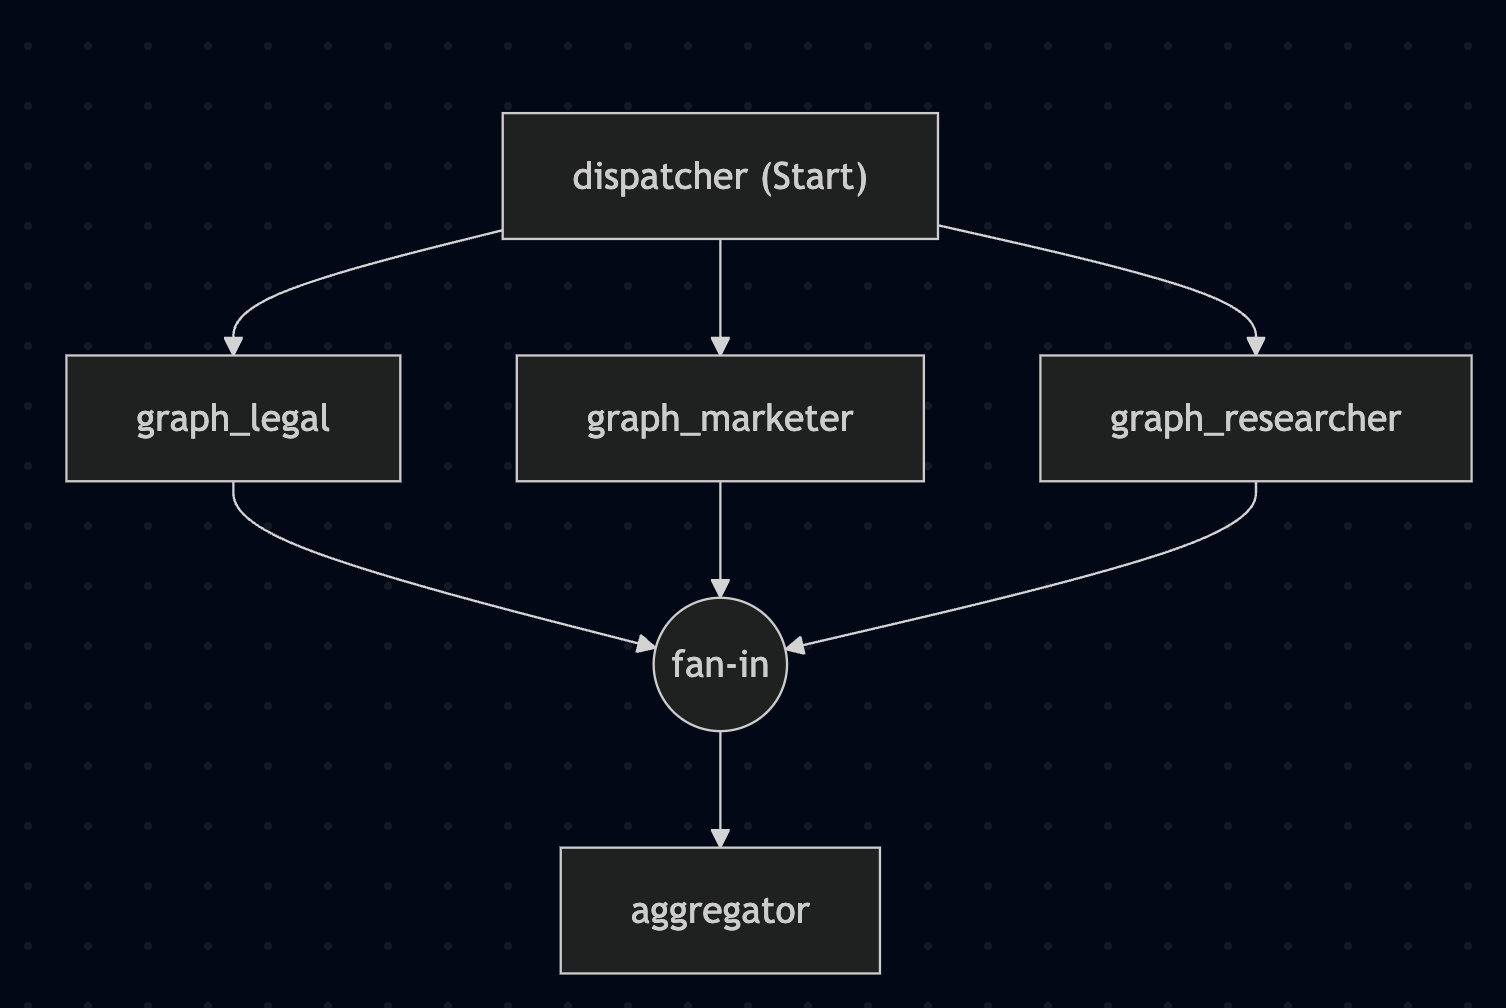

> **💡 Tip**: You can paste the Mermaid output into [mermaid.live](https://mermaid.live) to visualize and export as SVG/PNG.

## Step 4: Run the Custom Workflow

Execute the workflow and see how the dispatcher fans out to all agents, then the aggregator combines their responses.

In [32]:
# ============================================================
# Run the Custom Workflow
# ============================================================


async def run_custom_workflow_demo():
    """Run the custom fan-out/fan-in workflow showing each agent's output."""

    task = "We're launching a new AI tutoring platform for graduate students."

    print(f"📝 Task: {task}")
    print("\n" + "=" * 70)
    print("Running custom workflow (dispatcher → experts → aggregator)...")
    print("=" * 70 + "\n")

    async for event in custom_workflow.run_stream(task):
        # Print the event type and data for debugging
        event_type = type(event).__name__

        # Handle WorkflowOutputEvent - this contains the final aggregated output
        if isinstance(event, WorkflowOutputEvent):
            print(f"\n📊 Final Output:")
            print("-" * 60)
            print(event.data)
            print("-" * 60)
        else:
            # Print other events to see what's happening
            if hasattr(event, "data") and event.data:
                data_preview = (
                    str(event.data)[:200] if len(str(event.data)) > 200 else str(event.data)
                )
                print(f"[{event_type}] {data_preview}")

    print("\n" + "=" * 70)
    print("🎉 Workflow complete!")
    print("=" * 70)


# Run the demo
await run_custom_workflow_demo()

📝 Task: We're launching a new AI tutoring platform for graduate students.

Running custom workflow (dispatcher → experts → aggregator)...

[ExecutorInvokedEvent] We're launching a new AI tutoring platform for graduate students.
[ExecutorCompletedEvent] [AgentExecutorRequest(messages=[<agent_framework._types.ChatMessage object at 0x115ec5590>], should_respond=True)]
[ExecutorInvokedEvent] AgentExecutorRequest(messages=[<agent_framework._types.ChatMessage object at 0x115ec7e90>], should_respond=True)
[ExecutorInvokedEvent] AgentExecutorRequest(messages=[<agent_framework._types.ChatMessage object at 0x115fef350>], should_respond=True)
[ExecutorInvokedEvent] AgentExecutorRequest(messages=[<agent_framework._types.ChatMessage object at 0x115b57ad0>], should_respond=True)
[AgentRunUpdateEvent] 
[AgentRunUpdateEvent] 
[AgentRunUpdateEvent] Absolutely
[AgentRunUpdateEvent] !
[AgentRunUpdateEvent]  Here
[AgentRunUpdateEvent]  are
[AgentRunUpdateEvent]  several
[AgentRunUpdateEvent]  compelling
[

### Key Takeaways: Custom Workflow Graphs

| Aspect | Details |
|--------|---------|
| **WorkflowBuilder** | Define workflows as directed graphs with full control |
| **Executor** | Custom nodes for pre/post processing (dispatch, aggregate) |
| **Fan-out edges** | One node sends to multiple nodes (parallel) |
| **Fan-in edges** | Multiple nodes converge to one node (aggregation) |
| **WorkflowViz** | Generate Mermaid/GraphViz diagrams for documentation |
| **Best for** | Complex topologies, custom aggregation, visualization |

> **💡 Key Insight**: The built-in patterns (`ConcurrentBuilder`, `SequentialBuilder`, etc.) are syntactic sugar over `WorkflowBuilder`. When you need more control, use `WorkflowBuilder` directly to define your own graph topology.

## When Do You Need a Custom Workflow?

Use this decision tree to determine if you need `WorkflowBuilder` or if a built-in pattern is sufficient:

```
                              START
                                │
                                ▼
                    ┌───────────────────────┐
                    │ Does a built-in       │
                    │ pattern match your    │
                    │ topology?             │
                    └───────────┬───────────┘
                          YES   │   NO
                    ┌───────────┴───────────┐
                    ▼                       ▼
            ┌───────────────┐       ┌───────────────────┐
            │ Do you need   │       │ Use WorkflowBuilder│
            │ custom        │       │ (custom topology)  │
            │ aggregation?  │       └───────────────────┘
            └───────┬───────┘
              YES   │   NO
            ┌───────┴───────┐
            ▼               ▼
    ┌───────────────┐  ┌───────────────────┐
    │WorkflowBuilder│  │ Do you need       │
    │(custom agg)   │  │ visualization?    │
    └───────────────┘  └───────┬───────────┘
                         YES   │   NO
                       ┌───────┴───────┐
                       ▼               ▼
               ┌───────────────┐  ┌───────────────────┐
               │WorkflowBuilder│  │ Use built-in      │
               │(for WorkflowViz)│ │ pattern! ✅       │
               └───────────────┘  └───────────────────┘
```

## Quick Reference: Built-in vs Custom

| Question | If YES → | If NO → |
|----------|----------|---------|
| Need all agents to see the same input simultaneously? | **Concurrent** | Continue ↓ |
| Need agents to process in strict order (pipeline)? | **Sequential** | Continue ↓ |
| Need a manager to control who speaks? | **Group Chat** or **Magentic** | Continue ↓ |
| Need planning and progress tracking? | **Magentic** | Continue ↓ |
| Need agents to hand off based on context? | **Handoff** | Continue ↓ |
| Need custom pre/post processing logic? | **WorkflowBuilder** | Continue ↓ |
| Need conditional branching between agents? | **WorkflowBuilder** | Continue ↓ |
| Need to generate workflow diagrams? | **WorkflowBuilder** | Use closest built-in |

## Signs You Need WorkflowBuilder

✅ **Use WorkflowBuilder when:**
- You need **custom aggregation** logic (not just collecting all results)
- You need **conditional routing** based on content or metadata
- You need **hybrid topologies** (e.g., fan-out then sequential then fan-in)
- You need to **visualize** your workflow with Mermaid/GraphViz
- You need **custom executors** for pre/post processing
- None of the 5 patterns fit your use case

❌ **Don't use WorkflowBuilder when:**
- A built-in pattern matches your needs (simpler = better)
- You're just starting out (learn the patterns first)
- You don't need custom aggregation or routing

# Summary

## What You Learned

| Topic | Key Insight |
|-------|-------------|
| **Why Multi-Agent** | Specialized agents > one generalist for complex tasks |
| **Concurrent** | Fan-out for parallel, independent analysis |
| **Sequential** | Pipeline for step-by-step workflows |
| **Group Chat** | Star topology with manager-controlled turns |
| **Magentic** | Planning + progress tracking for complex tasks |
| **Handoff** | Mesh topology for dynamic routing |
| **Custom Workflows** | `WorkflowBuilder` for full control over topology |

## Key Concepts

```
┌─────────────────────────────────────────────────────────────────────┐
│                Microsoft Agent Framework Patterns                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Built-in Patterns (use when they fit):                            │
│  • ConcurrentBuilder  → Parallel processing, aggregated results    │
│  • SequentialBuilder  → Pipeline processing, shared context        │
│  • GroupChatBuilder   → Manager-controlled collaboration           │
│  • MagenticBuilder    → Planning + dynamic agent selection         │
│  • HandoffBuilder     → Direct agent-to-agent routing              │
│                                                                     │
│  Custom Workflows (use when you need more control):                │
│  • WorkflowBuilder    → Define your own graph topology             │
│  • Custom Executors   → Pre/post processing (dispatch, aggregate)  │
│  • WorkflowViz        → Generate Mermaid/GraphViz diagrams         │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

## When to Build Your Own Workflow

Start with built-in patterns. Graduate to `WorkflowBuilder` when you need:
- **Custom aggregation** — Control how results are combined
- **Conditional routing** — Branch based on content or metadata
- **Hybrid topologies** — Mix fan-out, fan-in, and sequential
- **Visualization** — Generate workflow diagrams for documentation

## Assignment

See the **[Week 4 Assignment](../docs/asigments.md)** for this week's deliverables.

> **Note**: The assignment builds on your Week 3 single agent — you'll extend it to a multi-agent system using the patterns from this lab.

## Resources

- [Microsoft Agent Framework Documentation](https://learn.microsoft.com/azure/ai-services/agents/)
- [MagenticOne Paper](https://arxiv.org/abs/2411.04468)
- [Multi-Agent Design Patterns](https://learn.microsoft.com/azure/ai-services/agents/concepts/multi-agent)